# TO-DO
- Refactor the names/ add comments to better understand. 
- Add the possibility to save weights and restart the training from them.
- Implement attention map.
- Find out how Tensorboard works. 
- Ty Ensemble on Classification (Potential Bright Idea :) 
- Implement Halting Thing: assign to each token an halting score $h_{k}^{l}$ where k= k-th token and l = layers depth 
- try patchyfing with convolutions

### QUESTIONS/DOUBTS
- We haven't implemented the $L_{distribution}$
- 3. A-ViT, second column, after equation (4): ..."We incorporate H(.) into the existing Vision trasnformer block by allocating a single neuron in the MLP layer to do the task". 

### REFERENCES

- https://arxiv.org/pdf/2112.07658.pdf
- https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

### 0: IMPORTING LIBRARIES AND SETTING THE SEEDS

In [1]:

# Importing PyTorch-related libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Importing PyTorch Lightning-Related libraries
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint

# Importing General Libraries
import os
import csv
import PIL
import random
import numpy as np
from PIL import Image
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt



In [2]:

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.
    
    Arguments:
        - seed {int} : Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    pl.seed_everything(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed.
seed_everything(31)

### 1: DATA INSPECTION

#### 1.1: CREATION OF THE LABEL DICTIONARY

In [3]:

# Initialize the Mapping Dictionary to be empty.
mapping_dict = {}

# Open the file in read mode.
with open('/kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt', 'r') as file:
    
    # Read each line from the file.
    for line in file:
        # Split the line into tokens based on whitespace.
        tokens = line.strip().split('\t')
        
        # Check if there are at least two tokens.
        if len(tokens) >= 2:
            # Extract the encoded label (left) and actual label (right).
            encoded_label, actual_label = tokens[0], tokens[1]
            
            # Add the mapping to the dictionary.
            mapping_dict[encoded_label] = actual_label

# Print the mapping dictionary.
#print(mapping_dict)


#### 1.2: DISPLAYING EXAMPLES OF THE DATASET

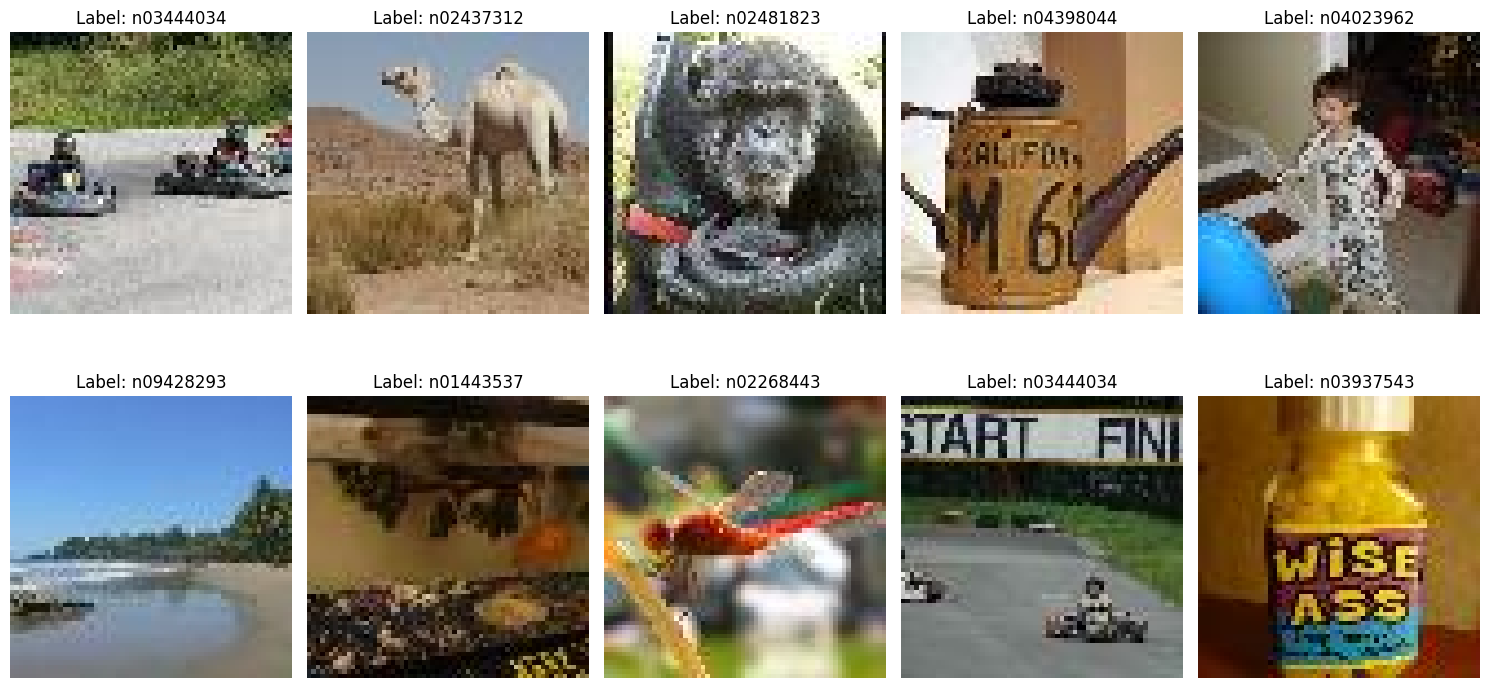

In [4]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))
for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, label = dataset0[index]

    # Display the image with its label
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')

# Displaying Datasets examples.
plt.tight_layout()
plt.show()

#### 1.3: DISPLAYING EXAMPLES OF THE DATASET WITH DECODED LABELS

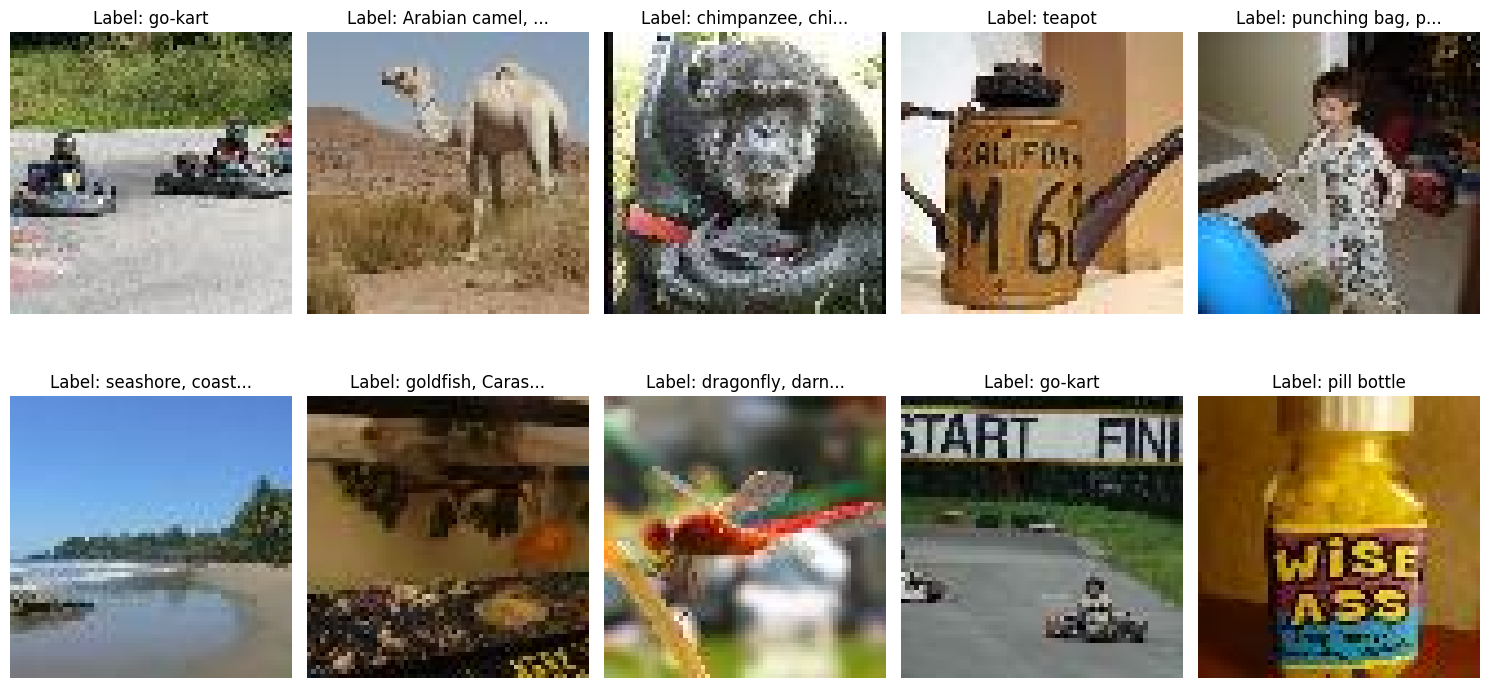

In [5]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))

for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    
    # Look up the actual label using the mapping dictionary.
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label..
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

# Displaying Dataset examples.
plt.tight_layout()
plt.show()

### 2: DATA-MODULE DEFINITION

#### 2.0: CUSTOMIZED TRANSFORM CLASS

In [6]:

class AdaViT_Transformations:
    
    def __init__(self):
        
        # Constructor - Nothing to initialize in this case
        pass

    def __call__(self, sample):
        """
        Call method to perform transformations on the input sample.

        Args:
        - sample (PIL.Image.Image or torch.Tensor): Input image sample.

        Returns:
        - transformed_sample (torch.Tensor): Transformed image sample.
        """

        # Define a series of image transformations using "torchvision.Compose" function.
        transform = transforms.Compose([
            transforms.ToTensor(),  
            # Additional transformations can be added here.
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
        ])

        # Apply the defined transformations to the input sample.
        transformed_sample = transform(sample)

        return transformed_sample

#### 2.1: CUSTOMIZED TRAINING SET VERSION

In [7]:

class CustomTrainingTinyImagenet(ImageFolder):
    
    def __init__(self, root, transform=None):
        """
        Custom dataset class for Tiny ImageNet Training data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        super(CustomTrainingTinyImagenet, self).__init__(root, transform=transform)

        # Create mappings between class labels and numerical indices
        self.class_to_index = {cls: idx for idx, cls in enumerate(sorted(self.classes))}
        self.index_to_class = {idx: cls for cls, idx in self.class_to_index.items()}

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - sample (torch.Tensor): Transformed image sample.
        - target (int): Numerical index corresponding to the class label.
        """
        # Retrieve the item and its label from the Dataset.
        path, target = self.samples[index]

        # Load the image using the default loader.
        sample = self.loader(path)

        # Apply the specified transformations, if any.
        if self.transform is not None:
            sample = self.transform(sample)

        # Adjust the directory depth to get the target label.
        target_str = os.path.basename(os.path.dirname(os.path.dirname(path)))

        # Convert string label to numerical index using the mapping.
        target = self.class_to_index[target_str]

        return sample, target

    def get_class_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        
        return self.index_to_class[index]

#### 2.2: CUSTOMIZED VALIDATION SET VERSION

In [8]:

class CustomValidationTinyImagenet(pl.LightningDataModule):
    
    def __init__(self, root, transform=None):
        """
        Custom data module for Tiny ImageNet Validation data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        self.root = Path(root)
        self.transform = transform

        # Load and preprocess labels
        self.labels = self.load_labels()
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels.values())))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def load_labels(self):
        """
        Method to load and Pre-Process Labels from the Validation Dataset.

        Returns:
        - labels (dict): Dictionary mapping image names to labels.
        """
        label_path = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt"
        labels = {}

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.split("\t")
            image_name, label = parts[0], parts[1]
            labels[image_name] = label

        return labels

    def __len__(self):
        """
        Method to get the length of the dataset.

        Returns:
        - length (int): Number of items in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - image (torch.Tensor): Transformed image sample.
        - label (int): Numerical index corresponding to the class label.
        """
        image_name = f"val_{index}.JPEG"
        image_path = self.root / image_name

        # Open the image using PIL and convert to RGB.
        image = Image.open(image_path).convert("RGB")

        # Apply the specified transformations, if any.
        if self.transform:
            image = self.transform(image)

        # Use the get method to handle cases where the key is not present.
        label_str = self.labels.get(image_name, 'Label not found')

        # Convert string label to numerical index using the mapping.
        label = self.label_to_index[label_str]

        return image, label

    def get_label_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        return self.index_to_label[index]

#### 2.3: GENERAL DATA-MODULE DEFINITION

In [9]:

class AViT_DataModule(pl.LightningDataModule):
    def __init__(self, train_data_dir, val_data_dir, batch_size, num_workers=4):
        """
        Custom data module for AViT model training and validation.

        Args:
        - train_data_dir (str): Directory path for the training dataset.
        - val_data_dir (str): Directory path for the validation dataset.
        - batch_size (int): Batch size for training and validation DataLoader.
        - num_workers (int, optional): Number of workers for DataLoader (default is 4).
        """
        super(AViT_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Use AdaViT transformations for data augmentation
        self.transform = AdaViT_Transformations()

    def setup(self, stage=None):
        """
        Method to load and configure datasets for Training and Validation.

        Args:
        - stage (str, optional): 'fit' for Training and 'test' for Validation (default is None).
        """
        # Load Train dataset using CustomTrainingTinyImagenet with the new directory structure.
        self.train_dataset = CustomTrainingTinyImagenet(self.train_data_dir, transform=self.transform)

        # Load Validation dataset.
        self.val_dataset = CustomValidationTinyImagenet(self.val_data_dir, transform=self.transform)

    def train_dataloader(self):
        """
        Method to return the DataLoader for the Training Dataset.

        Returns:
        - train_dataloader (DataLoader): DataLoader for Training.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        """
        Method to return the DataLoader for the Validation Dataset.

        Returns:
        - val_dataloader (DataLoader): DataLoader for Validation.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

#### 2.4: TESTING TRAINING AND VALIDATION DATALOADERS

In [10]:

def show_images_labels(images, labels, title):
    """
    Display Images with corresponding Labels.

    Parameters:
    - images (list of tensors): List of Image tensors.
    - labels (list): List of corresponding Labels.
    - title (str): Title for the entire subplot.

    Returns:
    None
    """
    # Create a Subplot with 1 row and len(images) columns.
    fig, axs = plt.subplots(1, len(images), figsize=(8, 4))
    
    # Set the title for the entire subplot.
    fig.suptitle(title)

    # Iterate over Images and Labels.
    for i, (img, label) in enumerate(zip(images, labels)):
        # Display each Image in a subplot.
        axs[i].imshow(transforms.ToPILImage()(img))
        
        # Set the title for each subplot with the corresponding label.
        axs[i].set_title(f"Label: {label}")
        
        # Turn off axis labels for better Visualization.
        axs[i].axis('off')

    # Show the entire subplot.
    plt.show()


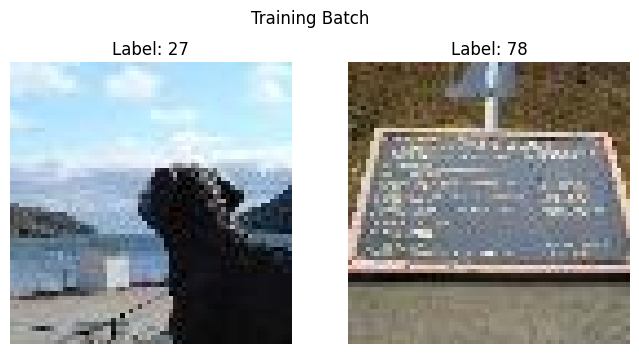

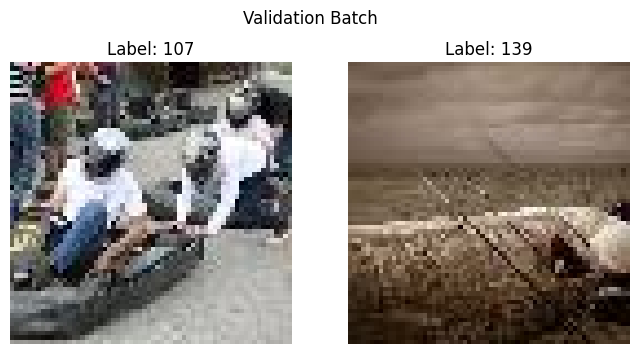

In [11]:

# Define the AViT_DataModule.
data_module = AViT_DataModule(
    train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/",
    val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/",
    batch_size=512  
)

# Setup the Dataloaders.
data_module.setup()

# Get a batch from the Training DataLoader.
train_dataloader = data_module.train_dataloader()
train_batch = next(iter(train_dataloader))

# Get a batch from the Validation DataLoader.
val_dataloader = data_module.val_dataloader()
val_batch = next(iter(val_dataloader))

# Show two Images from the Training Batch.
show_images_labels(train_batch[0][:2], train_batch[1][:2], title='Training Batch')

# Show two Images from the  Validation Batch
show_images_labels(val_batch[0][:2], val_batch[1][:2], title='Validation Batch')

### 3: MODEL DEFINITION

#### 3.0: PATCHING FUNCTION DEFINITION

In [12]:
def Make_Patches_from_Image(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Make_Patches_from_Image method is implemented for square images only!"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [13]:
# Helper function to visualize patches
def visualize_patches(images, n_patches, title):
    patches = Make_Patches_from_Image(images, n_patches)
    
    fig, axs = plt.subplots(n_patches, n_patches, figsize=(8, 8))
    fig.suptitle(title)
    
    patch_size = images.shape[-1] // n_patches

    for i in range(n_patches):
        for j in range(n_patches):
            patch_index = i * n_patches + j
            # Reshape each patch to (3, patch_size, patch_size)
            patch = patches[0, patch_index].reshape(3, patch_size, patch_size).cpu().numpy()
            axs[i, j].imshow(patch.transpose(1, 2, 0))
            axs[i, j].axis('off')

    plt.show()

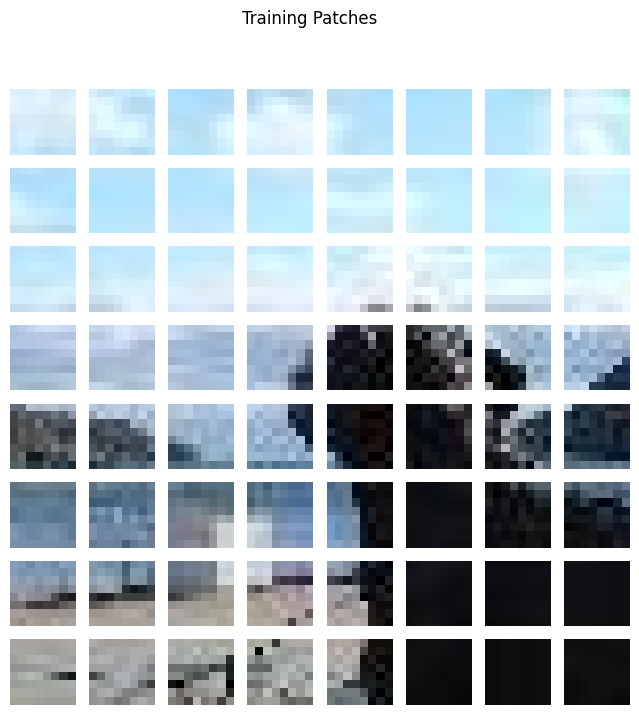

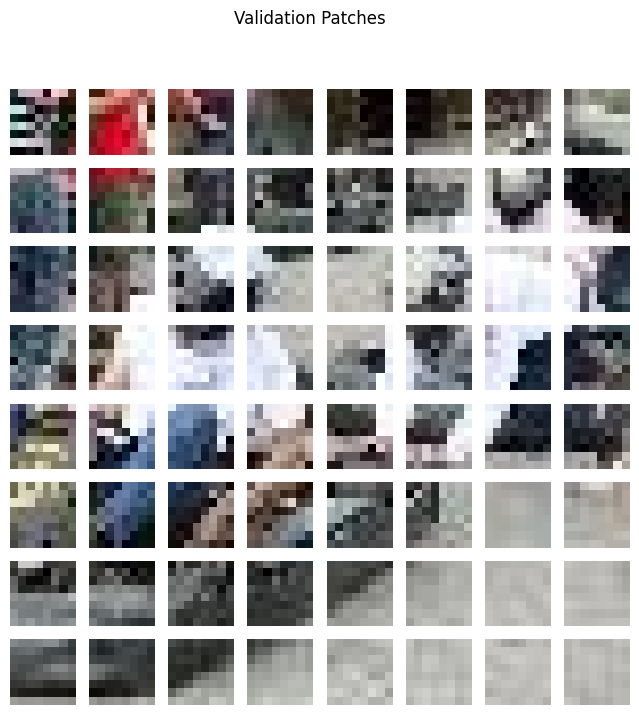

In [14]:
# Visualize patches for a Training Image.
visualize_patches(train_batch[0], n_patches=8, title='Training Patches')

# Visualize patches for a Validation Image
visualize_patches(val_batch[0], n_patches=8, title='Validation Patches')

#### 3.1: POSITIONAL EMBEDDING DEFINITION

In [15]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

#### 3.2: MULTI-HEAD SELF-ATTENTION DEFINITION

In [16]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
        # Initialize weights.
        self.initialize_weights_msa()
        
    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
    
    def initialize_weights_msa(self):
        # Initialize weights for linear layers
        for q_mapping, k_mapping, v_mapping in zip(self.q_mappings, self.k_mappings, self.v_mappings):
            nn.init.xavier_uniform_(q_mapping.weight)
            nn.init.xavier_uniform_(k_mapping.weight)
            nn.init.xavier_uniform_(v_mapping.weight)

#### 3.3: ViT BLOCK DEFINITION

In [17]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=10):
        super(MyViTBlock, self).__init__()
        
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
        # Initialize weights.
        self.initialize_weights_block()

    def forward(self, x):
        
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
    
    def initialize_weights_block(self):
        
        # Initialize weights for linear layers in mlp.
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

#### 3.4: ViT MODEL DEFINITION

In [18]:

def get_distribution_target(length=4, max=1, target_depth=3, buffer=0.02):
    """
    This generates the target distributional prior
    """
    # this gets the distributional target to regularize the ACT halting scores towards
    # now get a serios of length
    data = np.arange(length)
    data = norm.pdf(data, loc=target_depth, scale=1)
    scaling_factor = (1.-buffer) / sum(data[:target_depth])
    data *= scaling_factor

    return data

In [19]:
class MyViT(nn.Module):
        
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, out_d):
        # Super constructor
        super(MyViT, self).__init__()
        self.ponder_loss = 0
        self.distr_prior_loss = 0
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.mlp_ratio=100
        #halting prior distribution loss and target distribution
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        self.distr_target = torch.Tensor(get_distribution_target())
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.mlp_ratio * self.hidden_d),
            nn.GELU(),
            nn.Linear(self.mlp_ratio * self.hidden_d, out_d),
            nn.LogSoftmax(dim=-1)
        )
        
        # Initialize weights
        self.initialize_weights()

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = Make_Patches_from_Image(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Halting Procedure
        total_token_count=len(out[1]) # out.shape = [512,65,32]
        counter_token=0 #number of token not halted yet
        bs = out.size()[0]  # The batch size
        c_token = torch.zeros(bs,total_token_count)
        r = torch.ones(bs,total_token_count)
        rho = torch.zeros(bs,total_token_count)
        mask = torch.ones(bs,total_token_count)
        gamma = 5
        beta = -10
        alpha_p = 5e-4
        alpha_d = 0.1
        eps = 0.01
        output=None #final output of vision transformer block
        halting_score_layer=[]
        
        
        
        # Transformer Blocks
        for i,block in enumerate(self.blocks):
            #previous layers token are masked
            out.data = out.data * mask.float().view(bs,total_token_count, 1)
            out = block(out.data) #out.shape = [512,65,32]
            #if i < len(self.blocks):
                #out[:,:,0] = contains all the halting scores of images tokens ( t_O.shape = [512,65])
            t_0 = out[:,:,0]
            h_score = torch.sigmoid(gamma*t_0 + beta)
            h=[-1,h_score]
            _, h_token = h
            halting_score_layer.append(torch.mean(h[1][1:]))
            if i == len(self.blocks)-1:
                h_token = torch.ones(bs,total_token_count) 
            #self.halting_score_layer.append(torch.mean(h[1:]))
            #print(len(self.halting_score_layer))
            #last layer protection
            out = out * mask.float().view(bs,total_token_count, 1) #out.shape = [512,65,32]
            c_token = c_token + h_token #c_token.shape = [512,65]
            rho += mask.float() #rho.shape = [512,65]
        
            # Case 1: threshold reached in this iteration
            # token part
            reached_token = c_token > 1 - eps #shape [512,65]
            reached_token = reached_token.float() * mask.float()  #shape [512,65]
            delta1 = out * r.view(bs, total_token_count, 1) * reached_token.view(bs, total_token_count, 1) # [512,65,32] * [512,65,1] * [512,65,1]
            rho = rho + r * reached_token  #shape [512,65]

            # Case 2: threshold not reached
            # token part
            not_reached_token = c_token < 1 - eps
            not_reached_token = not_reached_token.float()
            r = r - (not_reached_token.float() * h_token)
            delta2 = out * h_token.view(bs, total_token_count, 1) * not_reached_token.view(bs, total_token_count, 1)
            
            #counter_token = counter_token + not_reached_token # These data points will need at least one more layer
            # Update the mask
            mask = c_token < 1 - eps
            
            if output is None:
                output = delta1 + delta2
            else:
                output = output + (delta1 + delta2)
                
            #Halting prior distribution
            
        
        #for i,elem in enumerate(self.halting_score_layer):
            #self.halting_score_layer[i] = elem / (total_token_count - 1)
        # KL loss
        halting_score_distr = torch.stack(halting_score_layer)
        halting_score_distr = halting_score_distr / torch.sum(halting_score_distr)
        halting_score_distr = torch.clamp(halting_score_distr, 0.01, 0.99)
        self.distr_prior_loss = alpha_d * self.kl_loss(halting_score_distr.log(), self.distr_target)
        # Multiply by alpha_p.
        self.ponder_loss = alpha_p * torch.mean(rho)
        # Getting the classification token only
        output = output[:, 0] #shape=[512,32]
        return self.mlp(output) # Map to output dimension, output category distribution
    

    def initialize_weights(self):
        
        # Initialize weights for linear layers, embeddings, etc.
        nn.init.xavier_uniform_(self.linear_mapper.weight)
        nn.init.normal_(self.class_token.data)

        # Initialize weights for classification MLP
        nn.init.xavier_uniform_(self.mlp[0].weight)
    

#### 3.5: GENERAL AViT MODEL DEFINITION

In [20]:
class AViT_Model(MyViT, pl.LightningModule):
    
    def __init__(self, input_d, n_patches, n_blocks, hidden_d, n_heads, out_d):
        
        super(AViT_Model, self).__init__(input_d, n_patches, n_blocks, hidden_d, n_heads, out_d)

        # Definition of the Weighted Cross Entropy Loss + Label Smoothing.
        self.loss = CrossEntropyLoss()
        #self.ponder_loss = self.ponder_loss

        # Definition of Accuracies, F1Score, Precision and Recall Metrics.
        self.acc_top1 = Accuracy(task="multiclass", num_classes=out_d)
        self.acc_top3 = Accuracy(task="multiclass", num_classes=out_d, top_k=3)
        self.acc_top5 = Accuracy(task="multiclass", num_classes=out_d, top_k=5)
        self.acc_top10 = Accuracy(task="multiclass", num_classes=out_d, top_k=10)
        self.f1score = MulticlassF1Score(num_classes=out_d, average='macro')
        self.precision = MulticlassPrecision(num_classes=out_d, average='macro')
        self.recall = MulticlassRecall(num_classes=out_d, average='macro')
        
        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
    
    def _step(self, batch):
        # Common computation of the metrics among Training, Validation and Test Set.
        x, y = batch
        preds = self(x) 
        loss = self.loss(preds, y) + self.ponder_loss + self.distr_prior_loss
        acc1 = self.acc_top1(preds, y)
        acc3 = self.acc_top3(preds,y)
        acc5 = self.acc_top5(preds,y)
        acc10 = self.acc_top10(preds,y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        
        return loss, acc1, acc3, acc5, acc10, f1score, precision, recall
    
    
    def training_step(self, batch, batch_idx):
        
        # Compute the Training Loss and Accracy.
        loss, acc, _, _, _, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        
        # Compute the Validation Loss and Accuracy.
        loss, acc1, acc3, acc5, acc10, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc1.item(), 
            "val_acc_3": acc3.item(), 
            "val_acc_5": acc5.item(), 
            "val_acc_10": acc10.item(), 
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc1, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_3", acc3, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_5", acc5, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_10", acc10, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean()
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean()
        acc_tot_3 = torch.tensor([item["val_acc_3"] for item in self.validation_step_outputs]).mean()
        acc_tot_5 = torch.tensor([item["val_acc_5"] for item in self.validation_step_outputs]).mean()
        acc_tot_10 = torch.tensor([item["val_acc_10"] for item in self.validation_step_outputs]).mean()

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)
        self.log("val_acc_3", acc_tot_3)
        self.log("val_acc_5", acc_tot_5)
        self.log("val_acc_10", acc_tot_10)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        message_accuracy_3 = f'      Validation Accuracy Top-3 -> {acc_tot_3}'
        message_accuracy_5 = f'      Validation Accuracy Top-5-> {acc_tot_5}'
        message_accuracy_10 = f'      Validation Accuracy Top-10-> {acc_tot_10}'
        print(message_loss + message_accuracy + message_accuracy_3 + message_accuracy_5 +message_accuracy_10 )

        # Clear the list to free memory.
        self.validation_step_outputs.clear()

    
    def configure_optimizers(self):
        
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=1.5e-3, weight_decay=1.5e-4)
        
        # Configure the Cosine Annealing Learning Rate Scheduler.
        scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1.5e-6)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
        

### 4: MODEL TRAINING

#### 4.1: CALLBACKS DEFINITION

In [21]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=30, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
tb_logger = TensorBoardLogger("/kaggle/working/logs", name="AViT")

# CSV CallBack Definition.
csv_logger = CSVLogger("/kaggle/working/logs", name="AViT")


#### 4.2: MODEL INSTANTIATION & TRAINING

In [22]:
# Initialize the model and data module.

# Image Flattened Dimension = 64*64*3 = 4096*3 = 12288
# n_patches = 16
# chw = (3, 64, 64)
# patch_size = (3, 64/16, 64/16) = (3, 4, 4) = (#channels, #h_patch, #w_patch)
# 256 patch of 48 elements = 256 * 48 = 12288
# hidden_d = linear mapping output dimension

# n_block = how many times the Transformer Block is repeated. 
# n_heads = how many times we repeat self-attention.
# out_d = number of output classes.

model = AViT_Model((3, 64, 64), 
                   n_patches=8, 
                   n_blocks=4, 
                   hidden_d=32, 
                   n_heads=4, 
                   out_d = 200)

datamodule = AViT_DataModule(train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", 
                             val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/", 
                             batch_size=512)

# Setup the dataloaders
data_module.setup()

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=25,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [23]:
# Train the model
trainer.fit(model, datamodule)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 5.391983985900879      Validation Accuracy -> 0.0078125      Validation Accuracy Top-3 -> 0.017578125      Validation Accuracy Top-5-> 0.0224609375      Validation Accuracy Top-10-> 0.0400390625


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 5.039877414703369      Validation Accuracy -> 0.03431180864572525      Validation Accuracy Top-3 -> 0.08367417752742767      Validation Accuracy Top-5-> 0.12262178957462311      Validation Accuracy Top-10-> 0.20504939556121826


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation Loss -> 4.941553592681885      Validation Accuracy -> 0.041417740285396576      Validation Accuracy Top-3 -> 0.1008099764585495      Validation Accuracy Top-5-> 0.1458754539489746      Validation Accuracy Top-10-> 0.23007237911224365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation Loss -> 4.8444013595581055      Validation Accuracy -> 0.05388327315449715      Validation Accuracy Top-3 -> 0.12286879867315292      Validation Accuracy Top-5-> 0.1763499528169632      Validation Accuracy Top-10-> 0.2720186114311218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation Loss -> 4.80253267288208      Validation Accuracy -> 0.06399356573820114      Validation Accuracy Top-3 -> 0.13559283316135406      Validation Accuracy Top-5-> 0.18833869695663452      Validation Accuracy Top-10-> 0.28925782442092896


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation Loss -> 4.778738498687744      Validation Accuracy -> 0.0633329525589943      Validation Accuracy Top-3 -> 0.1415211409330368      Validation Accuracy Top-5-> 0.1976907104253769      Validation Accuracy Top-10-> 0.29666244983673096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation Loss -> 4.76950216293335      Validation Accuracy -> 0.06522288173437119      Validation Accuracy Top-3 -> 0.1439625471830368      Validation Accuracy Top-5-> 0.20070083439350128      Validation Accuracy Top-10-> 0.3006146550178528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation Loss -> 4.763002395629883      Validation Accuracy -> 0.06518842279911041      Validation Accuracy Top-3 -> 0.14617416262626648      Validation Accuracy Top-5-> 0.20122356712818146      Validation Accuracy Top-10-> 0.3019014298915863


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation Loss -> 4.765193939208984      Validation Accuracy -> 0.06634880602359772      Validation Accuracy Top-3 -> 0.14460018277168274      Validation Accuracy Top-5-> 0.19690945744514465      Validation Accuracy Top-10-> 0.2988855838775635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation Loss -> 4.746826648712158      Validation Accuracy -> 0.0658375471830368      Validation Accuracy Top-3 -> 0.14755284786224365      Validation Accuracy Top-5-> 0.20722082257270813      Validation Accuracy Top-10-> 0.30355581641197205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation Loss -> 4.770401954650879      Validation Accuracy -> 0.06368910521268845      Validation Accuracy Top-3 -> 0.13627642393112183      Validation Accuracy Top-5-> 0.1916704922914505      Validation Accuracy Top-10-> 0.28947609663009644


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation Loss -> 4.712767601013184      Validation Accuracy -> 0.06900276243686676      Validation Accuracy Top-3 -> 0.14952895045280457      Validation Accuracy Top-5-> 0.2069106101989746      Validation Accuracy Top-10-> 0.3092084228992462


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation Loss -> 4.670797824859619      Validation Accuracy -> 0.07135799527168274      Validation Accuracy Top-3 -> 0.15865693986415863      Validation Accuracy Top-5-> 0.22066864371299744      Validation Accuracy Top-10-> 0.32579272985458374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation Loss -> 4.6499552726745605      Validation Accuracy -> 0.07764246314764023      Validation Accuracy Top-3 -> 0.16476908326148987      Validation Accuracy Top-5-> 0.22427043318748474      Validation Accuracy Top-10-> 0.32693013548851013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation Loss -> 4.6169586181640625      Validation Accuracy -> 0.08285845816135406      Validation Accuracy Top-3 -> 0.16828469932079315      Validation Accuracy Top-5-> 0.23127873241901398      Validation Accuracy Top-10-> 0.3435259461402893


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation Loss -> 4.595028877258301      Validation Accuracy -> 0.08460477739572525      Validation Accuracy Top-3 -> 0.17250114679336548      Validation Accuracy Top-5-> 0.23660385608673096      Validation Accuracy Top-10-> 0.3488740921020508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation Loss -> 4.593889236450195      Validation Accuracy -> 0.08471392095088959      Validation Accuracy Top-3 -> 0.1719381958246231      Validation Accuracy Top-5-> 0.2354319840669632      Validation Accuracy Top-10-> 0.34799519181251526


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Validation Loss -> 4.593299865722656      Validation Accuracy -> 0.0857134610414505      Validation Accuracy Top-3 -> 0.17031249403953552      Validation Accuracy Top-5-> 0.23733341693878174      Validation Accuracy Top-10-> 0.3506318926811218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Validation Loss -> 4.599264621734619      Validation Accuracy -> 0.08442095667123795      Validation Accuracy Top-3 -> 0.173868328332901      Validation Accuracy Top-5-> 0.2335018366575241      Validation Accuracy Top-10-> 0.3464326858520508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Validation Loss -> 4.620902061462402      Validation Accuracy -> 0.07803308963775635      Validation Accuracy Top-3 -> 0.16397634148597717      Validation Accuracy Top-5-> 0.22581572830677032      Validation Accuracy Top-10-> 0.3401711881160736


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Validation Loss -> 4.606185436248779      Validation Accuracy -> 0.08118680864572525      Validation Accuracy Top-3 -> 0.16889935731887817      Validation Accuracy Top-5-> 0.23265738785266876      Validation Accuracy Top-10-> 0.3411477506160736


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Validation Loss -> 4.617938041687012      Validation Accuracy -> 0.08156594634056091      Validation Accuracy Top-3 -> 0.16390739381313324      Validation Accuracy Top-5-> 0.22808480262756348      Validation Accuracy Top-10-> 0.33729320764541626


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Validation Loss -> 4.5745530128479      Validation Accuracy -> 0.08636258542537689      Validation Accuracy Top-3 -> 0.1733168661594391      Validation Accuracy Top-5-> 0.2383846491575241      Validation Accuracy Top-10-> 0.34947723150253296


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Validation Loss -> 4.557732582092285      Validation Accuracy -> 0.09017118066549301      Validation Accuracy Top-3 -> 0.18097427487373352      Validation Accuracy Top-5-> 0.2413717806339264      Validation Accuracy Top-10-> 0.3556755483150482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Validation Loss -> 4.5385026931762695      Validation Accuracy -> 0.09141199290752411      Validation Accuracy Top-3 -> 0.18746553361415863      Validation Accuracy Top-5-> 0.25259652733802795      Validation Accuracy Top-10-> 0.3640165328979492


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Validation Loss -> 4.524930953979492      Validation Accuracy -> 0.09526079893112183      Validation Accuracy Top-3 -> 0.18922334909439087      Validation Accuracy Top-5-> 0.25302159786224365      Validation Accuracy Top-10-> 0.3684857487678528


In [24]:
#print(result)

### 5: BEST MODEL EXTRAPOLATION

In [25]:
best_model_path = my_checkpoint_call.best_model_path
best_model = AViT_Model.load_from_checkpoint(checkpoint_path=best_model_path,
                                             input_d=(3, 64, 64), 
                                             n_patches=8, 
                                             n_blocks=4, 
                                             hidden_d=32,
                                             n_heads=4, 
                                             out_d = 200)

### 6: SAVING THE BEST MODEL

In [26]:
# Save it as a pth file.
# Specify the path where you want to save the model.
model_path = f"/kaggle/working/best_model_acc.pth"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), model_path)

# Save it as a CheckPoint (Specific of PyTorch Lightning = Model State Dictionary + Training State + Optimizer State)
# Specify the path where you want to save the model checkpoint.
ckpt_path = f"/kaggle/working/best_model_acc.ckpt"

# Save the model's state dict to the specified file
torch.save(best_model.state_dict(), ckpt_path)

### 7: TRAINING FROM A SAVED CHECKPOINT